In [6]:
import os
import zipfile

try:
    from google.colab import drive
    RUNNING_IN_COLAB = True
    
except ImportError:
    drive = None
    RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
    os.system('git clone https://github.com/vekshinnikita/face_recognition.git /content/face_recognition')
    os.chdir('/content/face_recognition') 
    
    drive.mount('/content/drive')
    
    zip_dataset_path = '/content/drive/MyDrive/recognition_dataset.zip'
    destination_dataset_path = '/content/face_recognition/'
    with zipfile.ZipFile(zip_dataset_path, 'r') as zip_ref:
      zip_ref.extractall(destination_dataset_path)

In [7]:
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from datetime import datetime

import torch
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2

from utils.display import show_image_with_bboxes
from dataset_classes.vgg_face2_classifier import VGGFace2ClassifierDataset, VGGFace2ClassifierArcDataset

from utils.system import get_available_device
from models.face_classifier_googlenet import FaceGoogLeNet, info_string as model_info_string
from loss.triplet_loss import TripletLoss
from loss.arcface_loss import ArcFaceLoss
from utils.classifier_model import aggregate_metrics, evaluate_recognition_batch, save_model


In [8]:
MODE = 'train' # 'train' | 'prod'
PATH_TO_SAVED_FILE = None # Путь к сохраненному файлу с параметрами

SAVE_BEST_DIR_PATH = './best_models/'
SAVE_BEST_FILE_NAME = 'googlenet_face_classifier_{start_datetime:%m-%d_%H:%M}_epoch_{epoch}.pt'

EPOCHS = 10
EMBEDDING_SIZE = 128

device = get_available_device()

GPU is not available, using CPU instead
Using device: cpu


In [9]:
SAVE_BEST_FILE_PATH = os.path.join(SAVE_BEST_DIR_PATH, SAVE_BEST_FILE_NAME)

def is_train():
    return MODE == 'train'

def is_load_from_saved():
    return PATH_TO_SAVED_FILE is not None

if is_load_from_saved():
    load_parameters = torch.load(PATH_TO_SAVED_FILE, weights_only=False, map_location=torch.device(device))

In [10]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

def reverse_transform(image: torch.Tensor):
    fn = v2.Compose([
        v2.Normalize(mean=(-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5), std=(1 / 0.5, 1 / 0.5, 1 / 0.5)),
    ])
    
    return fn(image)

if is_train():
    dataset = VGGFace2ClassifierArcDataset(
        './recognition_dataset/images/test',
        './recognition_dataset/labels/test',
        transform,
        reverse_transform
    )

In [11]:
# from dataset_classes.balanced_batch_sample import BalancedBatchSampler


if is_train():
    train_set, val_set, test_set = random_split(dataset, [0.7, 0.2, 0.1])

    batch_size = 16
    
    # train_sample = BalancedBatchSampler(train_set, batch_size=batch_size, min_samples_per_class=3)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [12]:
len(train_set.indices)

118564

In [13]:
model = FaceGoogLeNet(embedding_size=EMBEDDING_SIZE, pretrained=True).to(device)

if is_load_from_saved():
    model.load_state_dict(load_parameters['state_model'])

/Users/user/Documents/university/Дипломы/Никита/project/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/user/Documents/university/Дипломы/Никита/project/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Embedding: tensor([ 1.0306,  0.9782, -0.8878, -0.1396,  0.9937,  0.0764, -1.2403, -2.8557,
         1.1177, -0.5811,  0.2257, -0.2709,  1.1334,  0.2534,  0.5252, -0.7183,
         1.5279,  0.9808, -1.6906,  1.0631,  1.4348,  1.4691, -0.6941,  1.2802,
        -0.2143, -0.4659, -0.2983, -1.3108,  0.6560,  2.7634,  0.9708,  0.2902,
        -0.3529,  0.1487, -0.3081, -1.3410,  0.7766,  0.4776, -0.9038,  0.7040,
         0.3858, -0.3764,  0.7124,  1.3449, -2.0027, -0.9476,  1.2748,  1.1206,
        -0.5643,  0.4264, -1.5157,  0.1023,  0.2084,  0.5575,  0.0683,  0.5311,
         0.5750,  0.4104,  0.1639, -0.3984,  0.5921, -0.2927, -1.0708,  1.0890,
         0.7013,  1.0193, -0.6259, -0.1341, -0.0670,  1.7590,  0.5891, -1.3216,
        -0.0562, -2.3689,  0.0375,  0.2539, -0.5763,  0.6728,  1.0893, -0.4935,
        -1.0553,  0.2370, -2.2823, -0.2167,  0.6252, -0.2296,  0.2209,  0.6297,
        -1.0972, -0.6484, -0.2246, -0.3553, -0.4428, -0.2276, -1.9406,  0.8750,
        -0.9835, -1.8313, -0.

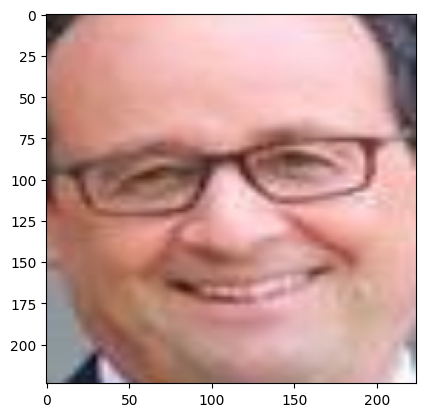

In [14]:
if is_train():
    model.eval()
    image, label = dataset[1100]
    
    data = image.unsqueeze(0).to(device)
    label = label.to(device)

    embedding = model.forward(data)[0]
    
    print(f'Embedding: {embedding}')
    print(f'Label class index: {label}')

    
    show_image_with_bboxes(reverse_transform(image))


In [15]:
# Выбор функции потерь

if is_train():
    model_loss = ArcFaceLoss(in_features=EMBEDDING_SIZE, out_features=len(dataset.class_idx_map), device=device)
    
    opt = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, # оптимизатор.
        mode= 'min', # 'max' или 'min" - следим, чтобы отслеживаемый параметр увеличивался (*!
        factor=0.1, # коэффициент, на который будет умножен lr
        patience=10, # кол-во.эпох без улучшения отслеживаемого параметра.
    )
    
    if is_load_from_saved():
        opt.load_state_dict(load_parameters['state_opt'])
        lr_scheduler.load_state_dict(load_parameters['state_lr_scheduler'])

In [16]:
if is_train():
    start_from_epoch = 0
    
    train_loss = []
    train_accuracy = []
    train_frr = []
    train_far = []

    val_loss = []
    val_accuracy = []
    val_frr = []
    val_far = []

    lr_list = []
    best_loss = None
    
    if is_load_from_saved():
        # EPOCHS = load_parameters['epoch']['EPOCHS']
        start_from_epoch = load_parameters['epoch']['save_epoch']
        
        train_loss = load_parameters['loss']['train_loss']
        val_loss = load_parameters['loss']['val_loss']
        # best_loss = load_parameters['loss']['best_loss']
        
        train_accuracy = load_parameters['metric']['train_accuracy']
        train_frr = load_parameters['metric']['train_frr']
        train_far = load_parameters['metric']['train_far']
        val_accuracy = load_parameters['metric']['val_accuracy']
        val_frr = load_parameters['metric']['val_frr']
        val_far = load_parameters['metric']['val_far']
        
        lr_list = load_parameters['lr_list']
        

In [17]:
import torch.nn.functional as F

start_datetime = datetime.now()

if is_train():
    threshold = 0.1
    saved_epoch = None
    # Цикл обучения
    
    train_correct=0
    data_size=0
    
    for epoch in range(start_from_epoch, EPOCHS):
        
        # Тренировка модели
        train_loop = tqdm(train_loader, leave=False)
        running_train_loss = []
        
        batch_results = []
        
        model.train()
        for images, targets in train_loop:

            images = images.to(device)
            targets = targets.to(device)
 
            # Прямой проход + расчет ошибки модели
            embeddings = model(images)
            
            loss = model_loss(embeddings, targets)
            
            # Обратный проход
            opt.zero_grad()
            loss.backward()
            
            # Шаг оптимизации
            opt.step()
            
            running_train_loss.append(loss.item())
            mean_train_loss = sum(running_train_loss)/len(running_train_loss)

            batch_metrics = evaluate_recognition_batch(embeddings, targets)
            batch_results.append(batch_metrics)
            
            train_loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss: .4f}")
            
            # Расчет значения метрики  
            # Сохранение значения функции потерь и метрики
    
        aggregated_metrics = aggregate_metrics(batch_results)
        
        train_loss.append(mean_train_loss)
        train_accuracy.append(aggregated_metrics['accuracy'])
        train_frr.append(aggregated_metrics['frr'])
        train_far.append(aggregated_metrics['far'])
        
        # Проверка модели (валидация)
        running_val_loss = []
        batch_results = []
        
        model.eval()
        with torch.no_grad():
            for images, targets in val_loader:
                
                images = images.to(device)
                targets = targets.to(device)
    
                # Прямой проход + расчет ошибки модели
                embeddings = model(images)
                
                loss = model_loss(embeddings, targets)
                
                running_val_loss.append(loss.item())
                mean_val_loss = sum(running_val_loss)/len(running_val_loss)
                
                batch_metrics = evaluate_recognition_batch(embeddings, targets)
                batch_results.append(batch_metrics)
                    
            aggregated_metrics = aggregate_metrics(batch_results)
            
            val_loss.append(mean_val_loss)
            val_accuracy.append(aggregated_metrics['accuracy'])
            val_frr.append(aggregated_metrics['frr'])
            val_far.append(aggregated_metrics['far'])
                    
            # Расчет значения метрики
            # Сохранение значения функции потерь и метрики
        
        lr_scheduler.step(mean_val_loss)
        lr = lr_scheduler.get_last_lr()
        lr_list.append(lr)
        
        if best_loss is None:
            best_loss = mean_val_loss
        
        if mean_val_loss < best_loss - best_loss * threshold:
            best_loss = mean_val_loss
            
            # if saved_epoch is not None:
            #     prefix = SAVE_BEST_FILE_NAME.split('{start_datetime:%m-%d_%H:%M}')[0] + '{start_datetime:%m-%d_%H:%M}'
            #     delete_files_with_prefix(
            #         SAVE_BEST_DIR_PATH,
            #         prefix.format(start_datetime=start_datetime)
            #     )
            
            saved_epoch = epoch+1
            save_model(
                file_path=SAVE_BEST_FILE_PATH,
                str_info=model_info_string,
                model=model,
                start_datetime=start_datetime,
                opt=opt,
                lr_scheduler=lr_scheduler,
                train_loss=train_loss,
                val_loss=val_loss,
                best_loss=best_loss,
                train_accuracy=train_accuracy,
                train_frr=train_frr,
                train_far=train_far,
                val_accuracy=val_accuracy,
                val_frr=val_frr,
                val_far=val_far,
                lr_list=lr_list,
                EPOCHS=EPOCHS,
                epoch=epoch+1,
            )
            print(f'Ha эпoxe - {epoch+1}, сохранена модель со значением функции потерь на валидации - {mean_val_loss: 4f}', end='\n\n')
            
        mean_train_accuracy = sum(train_accuracy)/len(train_accuracy)
        mean_train_frr = sum(train_frr)/len(train_frr)
        mean_train_far = sum(train_far)/len(train_far)
        mean_val_accuracy = sum(val_accuracy)/len(val_accuracy)
        mean_val_frr = sum(val_frr)/len(val_frr)
        mean_val_far = sum(val_far)/len(val_far)

        print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss: .4f}, train_accuracy={mean_train_accuracy: .4f}, train_frr={mean_train_frr: .4f}, train_far={mean_train_far: .4f}, val_loss={mean_val_loss: .4f}, val_accuracy={mean_val_accuracy: .4f}, val_frr={mean_val_frr: .4f}, val_far={mean_val_far: .4f}, lr={lr}")

  0%|          | 0/7411 [00:00<?, ?it/s]

KeyboardInterrupt: 

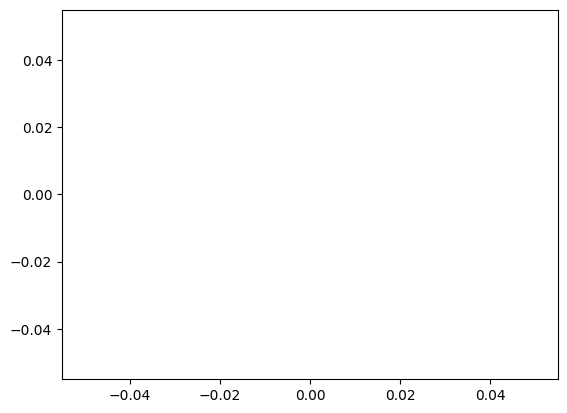

In [ ]:
if is_train():
    plt.plot(lr_list)
    plt.show()

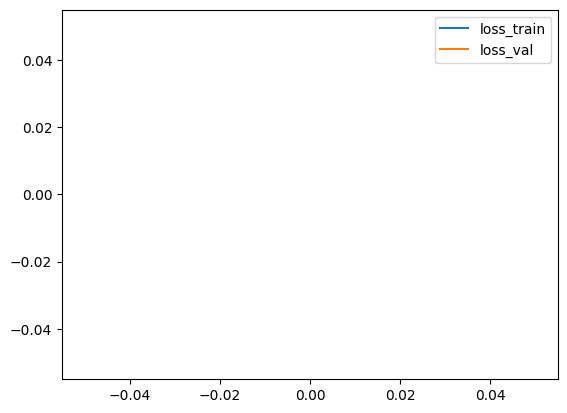

In [ ]:
if is_train():
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['loss_train', 'loss_val'])
    plt.show()

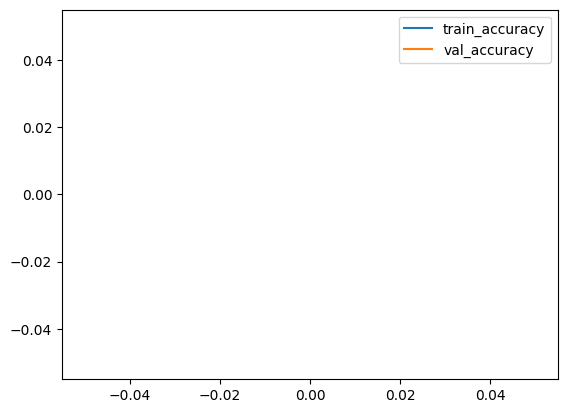

In [ ]:
if is_train():
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.legend(['train_accuracy', 'val_accuracy'])
    plt.show()

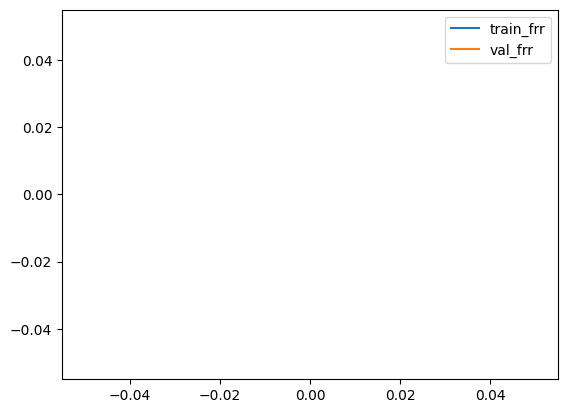

In [ ]:
if is_train():
    plt.plot(train_frr)
    plt.plot(val_frr)
    plt.legend(['train_frr', 'val_frr'])
    plt.show()

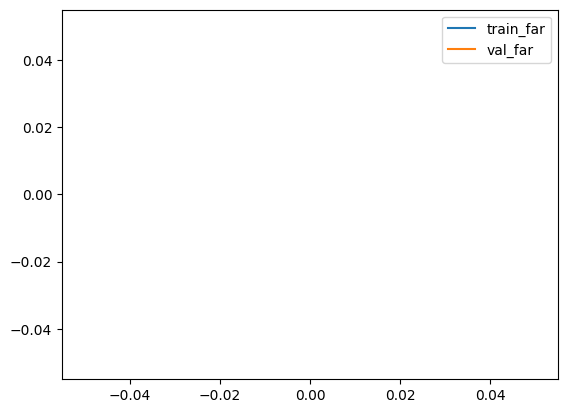

In [ ]:
if is_train():
    plt.plot(train_far)
    plt.plot(val_far)
    plt.legend(['train_far', 'val_far'])
    plt.show()